# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [339]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [340]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [341]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [342]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("hot_design_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [343]:
n_chains = 2
n_edges_per_chain = 2
bar_radius = 1.0

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 200, 100, 100

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params.flatten(),
        "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
        "static_parameters": [n_chains, n_edges_per_chain + 1],
        "string_parameters": [],
        "mesh_tesseract": TesseractReference(bar_3d_tess),
        "grid_size": [Lx, Ly, Lz],
        "grid_elements": [Nx, Ny, Nz],
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 180
Number of faces: 352
SDF shape: (200, 100, 100)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

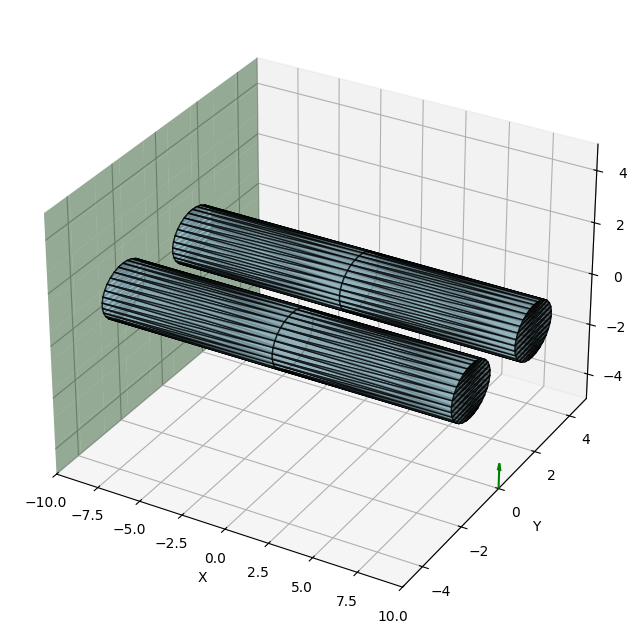

In [344]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

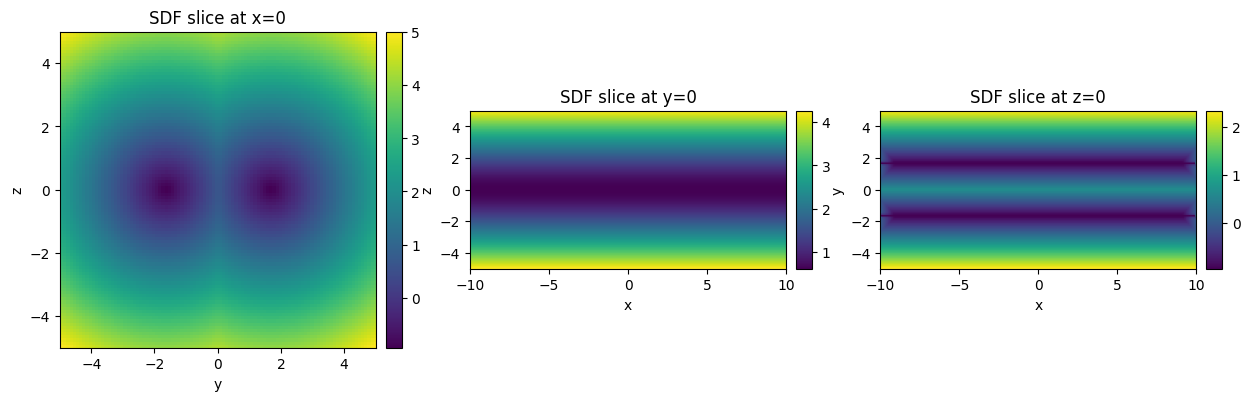

In [345]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

Lets test the gradient of the design Tesseract

In [346]:
primal, vjp_fun = jax.vjp(
    lambda params: apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
            "normalize_jacobian": True,
        },
    )["sdf"],
    initial_params,
)

grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

print("Gradient shape:", grad.shape)

Gradient shape: (2, 3, 3)


And figure out an approate epsilon for finite difference based Jacobian computation.

In [347]:
# Lets figure out a good epsilon value for FD jacobian computation
epsilons = jnp.logspace(-6, 0, 6)
mean_grads = []
std_grads = []

for i in range(len(epsilons)):
    eps = epsilons[i]
    primal, vjp_fun = jax.vjp(
        lambda params, eps=eps: apply_tesseract(
            design_tess,
            {
                "differentiable_parameters": params.flatten(),
                "non_differentiable_parameters": jnp.array(
                    [bar_radius], dtype=jnp.float32
                ),
                "static_parameters": [n_chains, n_edges_per_chain + 1],
                "string_parameters": [],
                "mesh_tesseract": TesseractReference(bar_3d_tess),
                "grid_size": [Lx, Ly, Lz],
                "grid_elements": [Nx, Ny, Nz],
                "epsilon": eps.item(),  # epsilon, only used for FD of the jacobian
                "normalize_jacobian": True,
            },
        )["sdf"],
        initial_params,
    )

    grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

    mean_grads.append(jnp.mean(jnp.abs(grad)))
    std_grads.append(jnp.std(grad))

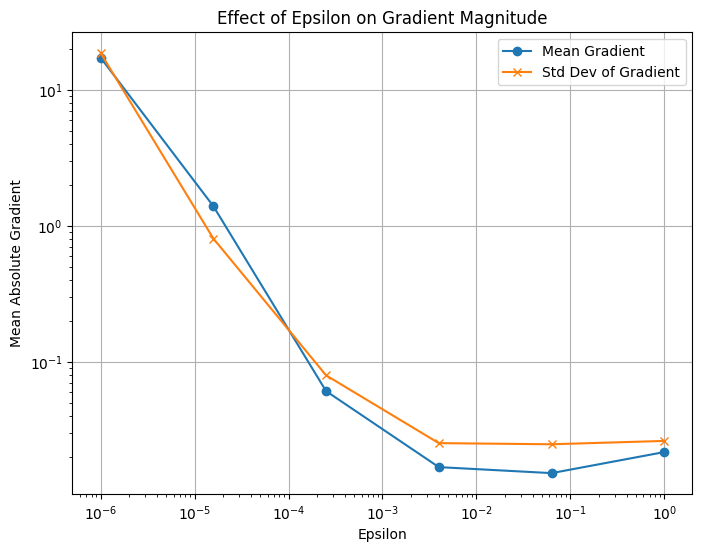

In [348]:
plt.figure(figsize=(8, 6))
plt.plot(epsilons, mean_grads, marker="o")
plt.plot(epsilons, std_grads, marker="x")
plt.xlabel("Epsilon")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Mean Absolute Gradient")
plt.title("Effect of Epsilon on Gradient Magnitude")
plt.grid(True)
plt.legend(["Mean Gradient", "Std Dev of Gradient"])

## Density and Sizing Field

rho min: 4.915646422887221e-05, rho max: 0.879593551158905


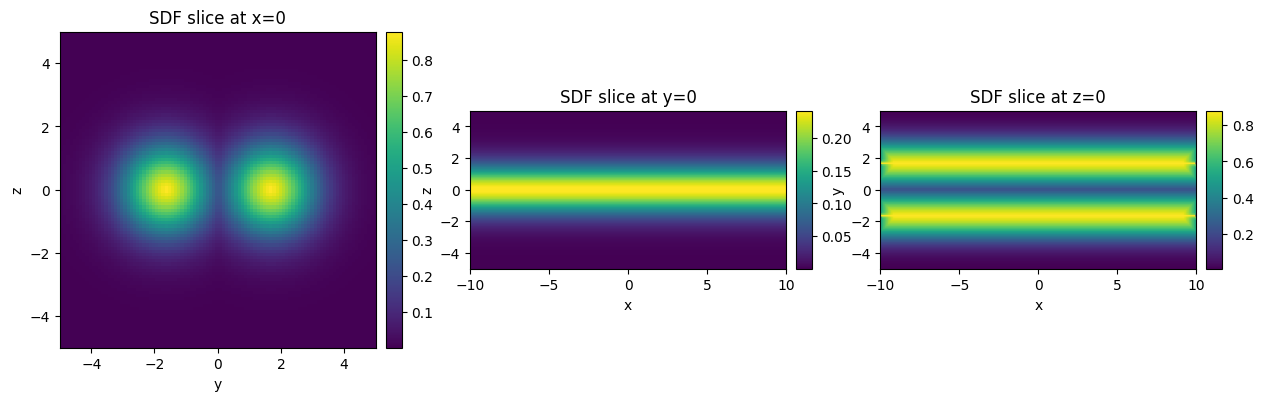

In [349]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.3333333432674408, max: 5.0


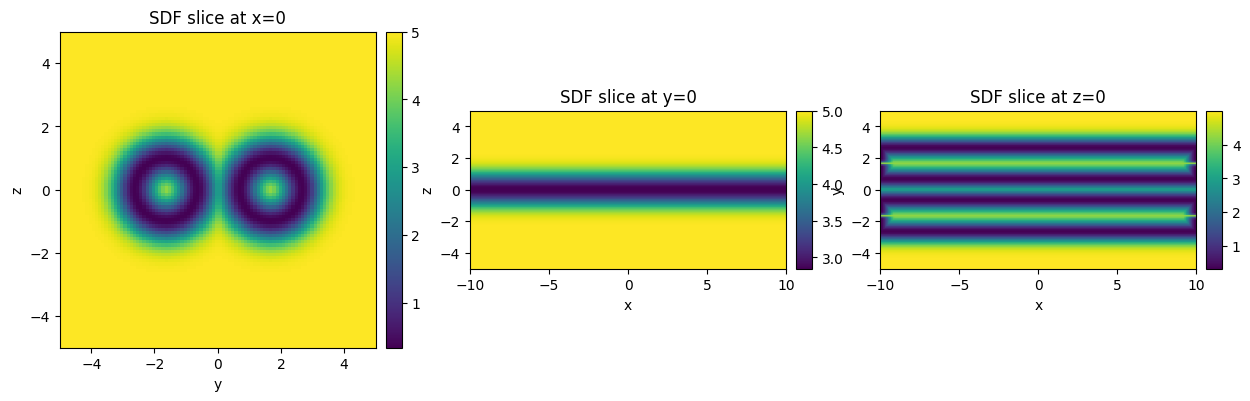

In [350]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing = sizing_field(sdf, min_size=Lx / 60, max_size=Lx / 4, scale=2.0)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [352]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        "field_values": rho,
        "max_subdivision_levels": 4,
        "max_points": 5000,
        "max_cells": 5000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

Mesh points: 1265, Mesh faces: 869


Lets check the gradient of the meshing Tesseract

In [353]:
max_points = 5000
max_cells = 5000

primal, vjp_fun = jax.vjp(
    lambda rho: apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 4,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )["mesh_cell_values"],
    rho,
)

grad = vjp_fun(jax.numpy.ones((max_cells), dtype=jax.numpy.float32) * 0.5)[0]

print("Gradient shape:", grad.shape)
print(f"Max grad: {jnp.max(grad)}, Min grad: {jnp.min(grad)}")

Gradient shape: (200, 100, 100)
Max grad: 0.5, Min grad: 0.5


Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [333]:
# Lets export it to a .vtk using pyvista
import pyvista as pv


def hex_to_pyvista(pts: np.ndarray, faces: np.ndarray) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    return pv.UnstructuredGrid(cells, cell_types, pts)


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"])
cells_np = np.array(adaptive_mesh["faces"])

hex_mesh = hex_to_pyvista(pts_np, cells_np)

print(hex_mesh)

hex_mesh.save("fem_shapeopt_mesh.vtk")

UnstructuredGrid (0x7c2a95118820)
  N Cells:    5000
  N Points:   5000
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -5.000e+00, 5.000e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   0


## Boundary Conditions

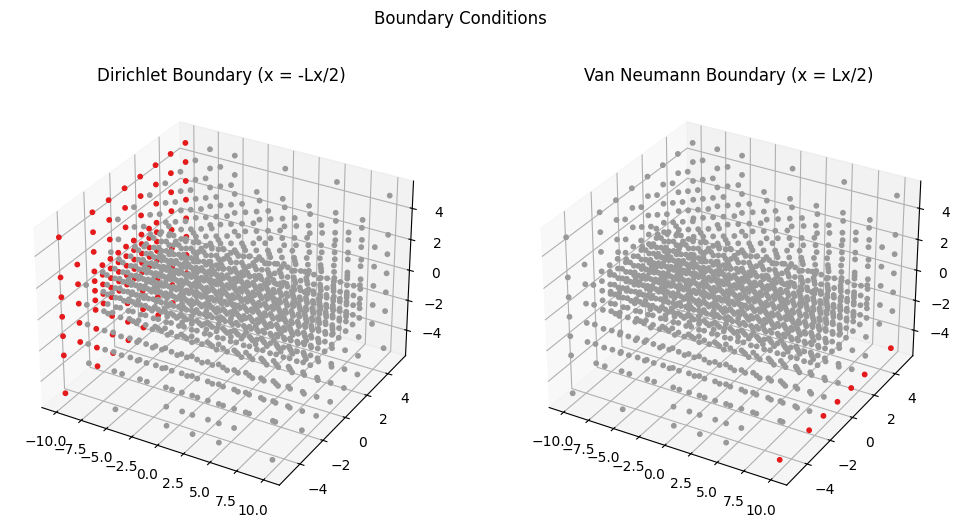

In [ ]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + 1e-5
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=0.1),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=0.1),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [355]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()W

fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [336]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.ones(adaptive_mesh["n_faces"]).reshape(-1, 1) * 0.5,
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 100.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-06 13:49:50][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 13:49:50][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 13:49:50][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 13:49:50][DEBUG] jax_fem: Done pre-computations, took 0.1556699275970459 [s]
[11-06 13:49:50][INFO] jax_fem: Solving a problem with 869 cells, 1265x3 = 3795 dofs.
[11-06 13:49:50][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


[11-06 13:49:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 13:49:50][DEBUG] jax_fem: Start timing
[11-06 13:49:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 13:49:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.3486 seconds
[11-06 13:49:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 13:49:51][DEBUG] jax_fem: Before, l_2 res = 5728.5192875244, relative l_2 res = 1.0
[11-06 13:49:51][DEBUG] jax_fem: Solving linear system...
[11-06 13:49:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-06 13:49:51][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.4922683033843636e-11
[11-06 13:49:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 13:49:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0182 seconds
[11-06 13:49:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 13:49:51][DEBUG] jax_fem: l_2 res = 1.5300934

Compliance: 22129.4434


Lets look a the gradient of the FEM Tesseract.

In [337]:
max_points = 5000
max_cells = 5000

primal, vjp_fun = jax.vjp(
    lambda rho: apply_tesseract(
        fem_tess,
        {
            "rho": adaptive_mesh["mesh_cell_values"].reshape(-1, 1),
            "hex_mesh": adaptive_mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": jnp.array([0.0]),
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": jnp.array([[0.0, 0.0, 10.0]]),
        },
    )["compliance"],
    rho,
)

grad = vjp_fun(jnp.array(100000.0, dtype=jnp.float32))[0]

print("Gradient shape:", grad.shape)
print(
    f"Max grad: {jnp.max(grad)}, Min grad: {jnp.min(grad)}, Mean grad: {jnp.mean(grad)}"
)

KeyError: 'mesh_cell_values'

In [356]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)


def loss(
    params: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    max_points = 5000
    max_cells = 5000

    # -- Tess 1 (design) --
    # Generate signed distance field from design parameters
    sdf = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
            "normalize_jacobian": True,
        },
    )["sdf"]

    # -- Local JAX code --
    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=2)

    sizing = sizing_field(sdf, min_size=Lx / 60, max_size=Lx / 4, scale=2.0)

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 4,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [358]:
import optax

optmizer = optax.adam(learning_rate=0.03)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []

grad_fn = jax.value_and_grad(loss)

for i in range(30):
    loss_value, grads = grad_fn(params)

    print(grads)
    print(params)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    params = params.at[..., 0].set(initial_params[..., 0])  # fix x-coordinates

    # Ensure parameters are within bounds
    params = params.at[..., 1].set(
        jnp.clip(params[..., 1], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    )

    # Clip the z-coordinates to be within the bar radius
    params = params.at[..., 2].set(
        jnp.clip(params[..., 2], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.2f}")

[11-06 14:04:24][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:04:24][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:04:24][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:04:24][DEBUG] jax_fem: Done pre-computations, took 0.1668095588684082 [s]
[11-06 14:04:24][INFO] jax_fem: Solving a problem with 869 cells, 1265x3 = 3795 dofs.
[11-06 14:04:24][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:04:25][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:04:25][DEBUG] jax_fem: Start timing
[11-06 14:04:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:04:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.3445 seconds
[11-06 14:04:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:04:25][DEBUG] jax_fem: Before, l_2 res = 572.85192875244, relative l_2 res = 

[[[ 0.9204646   1.6751708  -0.03217246]
  [-0.22347128  0.18525496 -0.08055666]
  [-0.13185342  0.03297287 -0.17346187]]

 [[ 0.7371003  -1.072439   -0.3546319 ]
  [ 0.57762927 -0.78205854  0.09874505]
  [ 0.08319659  0.06291813 -0.33637738]]]
[[[-10.         -1.6666666   0.       ]
  [  0.         -1.6666666   0.       ]
  [ 10.         -1.6666666   0.       ]]

 [[-10.          1.6666666   0.       ]
  [  0.          1.6666666   0.       ]
  [ 10.          1.6666666   0.       ]]]
Iteration 1, Loss: 9100.40


[11-06 14:04:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:04:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:04:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:04:41][DEBUG] jax_fem: Done pre-computations, took 0.9554977416992188 [s]
[11-06 14:04:41][INFO] jax_fem: Solving a problem with 939 cells, 1377x3 = 4131 dofs.
[11-06 14:04:41][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:04:44][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:04:44][DEBUG] jax_fem: Start timing
[11-06 14:04:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:04:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.5766 seconds
[11-06 14:04:46][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:04:46][DEBUG] jax_fem: Before, l_2 res = 562.1811704931349, relative l_2 res 

[[[ 0.36532655  0.70962805 -0.2240265 ]
  [-0.40337083 -0.13945769 -0.26587117]
  [-0.41944137 -0.23567067 -0.37844202]]

 [[-0.42437825 -1.2445482  -0.43199253]
  [-0.53334177 -0.46658745 -0.3658128 ]
  [-0.14022727 -0.49011707 -0.39543137]]]
[[[-10.          -1.6966666    0.02999999]
  [  0.          -1.6966666    0.03      ]
  [ 10.          -1.6966666    0.03      ]]

 [[-10.           1.6966666    0.03      ]
  [  0.           1.6966666   -0.03      ]
  [ 10.           1.6366667    0.03      ]]]
Iteration 2, Loss: 9447.22


[11-06 14:05:14][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:05:14][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:05:14][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:05:14][DEBUG] jax_fem: Done pre-computations, took 0.9517323970794678 [s]
[11-06 14:05:14][INFO] jax_fem: Solving a problem with 1002 cells, 1451x3 = 4353 dofs.
[11-06 14:05:14][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:05:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:05:17][DEBUG] jax_fem: Start timing
[11-06 14:05:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:05:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.5153 seconds
[11-06 14:05:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:05:19][DEBUG] jax_fem: Before, l_2 res = 557.7103892665963, relative l_2 res

[[[ 5.3569078e-01  1.0605172e+00  2.0669954e-01]
  [-2.8308656e-04  1.3142557e-01  3.9056122e-02]
  [-3.4240047e-06 -2.0322648e-06  3.9635734e-06]]

 [[ 8.4926017e-02 -6.5604264e-01  2.7560651e-02]
  [-3.7034618e-04 -6.7003705e-02  2.0167943e-04]
  [ 1.6098024e-04  1.7117077e-03  2.5512135e-04]]]
[[[-10.          -1.7238861    0.05495371]
  [  0.          -1.699293     0.05719213]
  [ 10.          -1.6773416    0.05866802]]

 [[-10.           1.7267001    0.06000904]
  [  0.           1.7253693   -0.01368275]
  [ 10.           1.656251     0.06002859]]]
Iteration 3, Loss: 9564.52


[11-06 14:05:46][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:05:46][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:05:46][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:05:47][DEBUG] jax_fem: Done pre-computations, took 0.9517996311187744 [s]
[11-06 14:05:47][INFO] jax_fem: Solving a problem with 1030 cells, 1485x3 = 4455 dofs.
[11-06 14:05:47][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:05:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:05:49][DEBUG] jax_fem: Start timing
[11-06 14:05:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:05:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.5272 seconds
[11-06 14:05:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:05:51][DEBUG] jax_fem: Before, l_2 res = 553.2034780573651, relative l_2 res

[[[ 3.7487033e-01  8.3177793e-01  2.2169265e-01]
  [ 1.7035212e-03  4.4673122e-02 -8.8961631e-02]
  [-6.0370396e-04  2.0650934e-02  3.5791036e-02]]

 [[ 5.9372410e-02 -6.5809900e-01  3.7782922e-02]
  [-4.2900332e-04 -7.6813757e-02  5.6664017e-03]
  [ 2.7385965e-04  7.4409270e-03  8.0204633e-04]]]
[[[-1.0000000e+01 -1.7517177e+00  5.6266092e-02]
  [ 0.0000000e+00 -1.7105145e+00  7.5337365e-02]
  [ 1.0000000e+01 -1.6624031e+00  8.0828309e-02]]

 [[-1.0000000e+01  1.7553699e+00  8.2233384e-02]
  [ 0.0000000e+00  1.7489041e+00 -1.0796888e-03]
  [ 1.0000000e+01  1.6713232e+00  8.3231352e-02]]]
Iteration 4, Loss: 9674.35


[11-06 14:06:20][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:06:20][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:06:20][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:06:21][DEBUG] jax_fem: Done pre-computations, took 0.9532511234283447 [s]
[11-06 14:06:21][INFO] jax_fem: Solving a problem with 1037 cells, 1492x3 = 4476 dofs.
[11-06 14:06:21][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:06:23][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:06:23][DEBUG] jax_fem: Start timing
[11-06 14:06:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:06:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.5413 seconds
[11-06 14:06:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:06:26][DEBUG] jax_fem: Before, l_2 res = 553.203478057365, relative l_2 res 

[[[ 1.8196368e-01  7.9158580e-01  1.8215904e-01]
  [-1.9521081e-04  6.1435632e-02  5.0337813e-03]
  [-2.3992651e-03  1.2772530e-02  1.4114062e-02]]

 [[ 5.9789032e-02 -6.4963818e-01  4.0303316e-02]
  [-5.1518733e-04 -9.3621649e-02 -5.1728473e-03]
  [ 2.9484858e-04  1.6841073e-02  4.6297410e-03]]]
[[[-1.00000000e+01 -1.77932930e+00  4.69144955e-02]
  [ 0.00000000e+00 -1.72246480e+00  9.47789624e-02]
  [ 1.00000000e+01 -1.65172112e+00  9.74188447e-02]]

 [[-1.00000000e+01  1.78346241e+00  9.92209166e-02]
  [ 0.00000000e+00  1.76957774e+00  8.98186211e-03]
  [ 1.00000000e+01  1.68340528e+00  1.02210656e-01]]]
Iteration 5, Loss: 9591.60


[11-06 14:06:48][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:06:48][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:06:48][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:06:48][DEBUG] jax_fem: Done pre-computations, took 0.19356346130371094 [s]
[11-06 14:06:48][INFO] jax_fem: Solving a problem with 1037 cells, 1492x3 = 4476 dofs.
[11-06 14:06:48][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:06:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:06:49][DEBUG] jax_fem: Start timing
[11-06 14:06:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:06:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.3630 seconds
[11-06 14:06:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:06:49][DEBUG] jax_fem: Before, l_2 res = 553.203478057365, relative l_2 res

[[[ 1.0368243e-01  7.8107035e-01  1.7483649e-01]
  [ 4.1489568e-04  1.9048758e-02  6.0552065e-03]
  [-2.5953460e-04  3.1720359e-02  6.7747189e-03]]

 [[ 6.5928847e-02 -6.4541203e-01  3.4402572e-02]
  [-6.0154678e-04 -6.7453347e-02  3.3575417e-03]
  [-2.4333938e-03  9.1769686e-03  7.6285205e-03]]]
[[[-10.          -1.8067644    0.03268845]
  [  0.          -1.7359465    0.11092887]
  [ 10.          -1.6435804    0.11088028]]

 [[-10.           1.8112437    0.11236729]
  [  0.           1.7886271    0.01770908]
  [ 10.           1.6930532    0.11810566]]]
Iteration 6, Loss: 9511.19


[11-06 14:07:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:07:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:07:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:07:06][DEBUG] jax_fem: Done pre-computations, took 0.944354772567749 [s]
[11-06 14:07:06][INFO] jax_fem: Solving a problem with 1051 cells, 1509x3 = 4527 dofs.
[11-06 14:07:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:07:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:07:08][DEBUG] jax_fem: Start timing
[11-06 14:07:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:07:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.5257 seconds
[11-06 14:07:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:07:11][DEBUG] jax_fem: Before, l_2 res = 553.2034780573651, relative l_2 res 

[[[ 6.36210442e-02  7.25009382e-01  1.32909462e-01]
  [-5.72806981e-04  4.59492132e-02 -7.15780421e-04]
  [-6.01469364e-05  8.13710096e-04 -9.41061066e-04]]

 [[ 6.19041994e-02 -6.49164319e-01  1.23375291e-02]
  [-6.75470510e-04 -7.68806189e-02 -4.73794714e-03]
  [ 1.61779273e-04  1.35539565e-02  7.24588055e-03]]]
[[[-10.          -1.8341019    0.01534362]
  [  0.          -1.7486148    0.12452228]
  [ 10.          -1.6386886    0.12222645]]

 [[-10.           1.8388491    0.12271792]
  [  0.           1.8061478    0.02509147]
  [ 10.           1.7010759    0.13157298]]]
Iteration 7, Loss: 9429.76


[11-06 14:07:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:07:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:07:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:07:33][DEBUG] jax_fem: Done pre-computations, took 0.1990971565246582 [s]
[11-06 14:07:33][INFO] jax_fem: Solving a problem with 1051 cells, 1509x3 = 4527 dofs.
[11-06 14:07:33][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:07:34][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:07:34][DEBUG] jax_fem: Start timing
[11-06 14:07:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:07:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.3508 seconds
[11-06 14:07:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:07:34][DEBUG] jax_fem: Before, l_2 res = 553.2034780573651, relative l_2 res

[[[ 5.77971302e-02  6.86705112e-01  1.06261246e-01]
  [-8.58279585e-04  7.41912946e-02 -1.25293676e-02]
  [ 7.66740995e-04 -1.91956423e-02 -7.41501898e-03]]

 [[ 6.73851967e-02 -6.46153390e-01 -4.90654958e-03]
  [-5.97105478e-04 -6.07606657e-02  4.15449124e-03]
  [ 1.76359637e-04  3.65399197e-03  1.84276002e-03]]]
[[[-1.0000000e+01 -1.8612480e+00 -3.4613162e-03]
  [ 0.0000000e+00 -1.7620140e+00  1.3643044e-01]
  [ 1.0000000e+01 -1.6344678e+00  1.3216935e-01]]

 [[-1.0000000e+01  1.8663749e+00  1.3142149e-01]
  [ 0.0000000e+00  1.8226594e+00  3.1728413e-02]
  [ 1.0000000e+01  1.7076622e+00  1.4312033e-01]]]
Iteration 8, Loss: 9357.36


[11-06 14:07:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:07:49][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:07:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:07:50][DEBUG] jax_fem: Done pre-computations, took 0.9395644664764404 [s]
[11-06 14:07:50][INFO] jax_fem: Solving a problem with 1058 cells, 1516x3 = 4548 dofs.
[11-06 14:07:50][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:07:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:07:53][DEBUG] jax_fem: Start timing
[11-06 14:07:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:07:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.5167 seconds
[11-06 14:07:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:07:55][DEBUG] jax_fem: Before, l_2 res = 553.2034780573651, relative l_2 res

[[[ 4.9952734e-02  6.7683554e-01  7.4524760e-02]
  [-8.0415589e-04  6.8033032e-02  2.2959360e-04]
  [ 8.6445682e-05  6.8011936e-03  2.1921481e-04]]

 [[ 7.5323783e-02 -6.4295089e-01 -1.3319556e-02]
  [-1.2909623e-03 -5.2043512e-02 -6.1192893e-04]
  [ 1.3532147e-03 -7.6824782e-04  1.5793754e-03]]]
[[[-10.          -1.8881693   -0.02289639]
  [  0.          -1.7772341    0.14755288]
  [ 10.          -1.6295758    0.14119776]]

 [[-10.           1.8938568    0.13922383]
  [  0.           1.8381602    0.03741542]
  [ 10.           1.7133582    0.15324701]]]
Iteration 9, Loss: 9287.01


[11-06 14:08:17][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:08:17][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:08:17][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:08:18][DEBUG] jax_fem: Done pre-computations, took 0.19773292541503906 [s]
[11-06 14:08:18][INFO] jax_fem: Solving a problem with 1058 cells, 1516x3 = 4548 dofs.
[11-06 14:08:18][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:08:18][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:08:18][DEBUG] jax_fem: Start timing
[11-06 14:08:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:08:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.3693 seconds
[11-06 14:08:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:08:19][DEBUG] jax_fem: Before, l_2 res = 553.2034780573651, relative l_2 re

[[[ 3.4791593e-02  6.5334541e-01  3.5425719e-02]
  [-2.8237544e-03  5.6063227e-02 -1.7345155e-02]
  [ 2.8955494e-04 -3.8845562e-03 -1.9897118e-03]]

 [[ 5.0831042e-02 -6.4796424e-01 -2.8385241e-02]
  [-5.8039464e-04 -5.8216594e-02  4.1422234e-03]
  [ 4.3230239e-06 -5.9694597e-03 -3.8662888e-04]]]
[[[-10.          -1.9149125   -0.04217848]
  [  0.          -1.7937351    0.1574152 ]
  [ 10.          -1.625648     0.14920488]]

 [[-10.           1.9213148    0.14649604]
  [  0.           1.8527224    0.04248773]
  [ 10.           1.7184376    0.16219203]]]
Iteration 10, Loss: 9220.84


[11-06 14:08:35][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:08:35][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:08:35][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:08:36][DEBUG] jax_fem: Done pre-computations, took 0.9657270908355713 [s]
[11-06 14:08:36][INFO] jax_fem: Solving a problem with 1065 cells, 1523x3 = 4569 dofs.
[11-06 14:08:36][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:08:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:08:38][DEBUG] jax_fem: Start timing
[11-06 14:08:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:08:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.5204 seconds
[11-06 14:08:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:08:40][DEBUG] jax_fem: Before, l_2 res = 553.203478057365, relative l_2 res 

[[[ 3.8151670e-02  6.3197118e-01 -1.5734319e-02]
  [-1.4587665e-03  4.3206081e-02 -2.6951455e-02]
  [ 2.4203776e-04  4.0173354e-03 -2.8981612e-04]]

 [[ 6.5040827e-02 -6.3539064e-01 -2.5707822e-02]
  [-1.2603662e-03 -4.8944883e-02  4.8201066e-05]
  [ 4.0866566e-05 -5.1144059e-03 -1.2421728e-03]]]
[[[-10.          -1.9414669   -0.06039067]
  [  0.          -1.8108953    0.16705905]
  [ 10.          -1.621909     0.1564204 ]]

 [[-10.           1.9487853    0.153712  ]
  [  0.           1.8666049    0.04685493]
  [ 10.           1.7231464    0.17018612]]]
Iteration 11, Loss: 9160.04


[11-06 14:09:03][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:09:03][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:09:03][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:09:03][DEBUG] jax_fem: Done pre-computations, took 0.20232224464416504 [s]
[11-06 14:09:03][INFO] jax_fem: Solving a problem with 1065 cells, 1523x3 = 4569 dofs.
[11-06 14:09:03][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:09:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:09:04][DEBUG] jax_fem: Start timing
[11-06 14:09:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:09:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.3191 seconds
[11-06 14:09:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:09:04][DEBUG] jax_fem: Before, l_2 res = 553.203478057365, relative l_2 res

[[[ 3.7431043e-02  6.2903750e-01 -4.7763765e-02]
  [ 6.2978780e-04  4.3843687e-02 -2.8801549e-02]
  [ 4.1343432e-04  1.4450810e-02  3.7298002e-03]]

 [[ 6.5930530e-02 -6.3198268e-01 -3.4495018e-02]
  [-7.8600523e-04 -6.1591074e-02 -5.3002606e-03]
  [ 7.5408883e-05 -1.1752979e-03 -3.4493874e-03]]]
[[[-10.          -1.9678241   -0.07624049]
  [  0.          -1.8281616    0.17698655]
  [ 10.          -1.6187996    0.16289692]]

 [[-10.           1.976242     0.16083333]
  [  0.           1.8797911    0.05076692]
  [ 10.           1.7275164    0.17738506]]]
Iteration 12, Loss: 9105.17


[11-06 14:09:16][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:09:16][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:09:16][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:09:17][DEBUG] jax_fem: Done pre-computations, took 0.9574429988861084 [s]
[11-06 14:09:17][INFO] jax_fem: Solving a problem with 1058 cells, 1519x3 = 4557 dofs.
[11-06 14:09:17][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:09:18][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:09:18][DEBUG] jax_fem: Start timing
[11-06 14:09:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:09:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.3706 seconds
[11-06 14:09:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:09:19][DEBUG] jax_fem: Before, l_2 res = 556.3835755173482, relative l_2 res

[[[ 2.5329299e-02  6.3474268e-01 -1.5569860e-01]
  [-1.8230913e-03  4.5393586e-02 -4.1968480e-02]
  [ 7.5728021e-04 -4.9099652e-03 -5.0715776e-03]]

 [[ 7.8963540e-02 -5.4275215e-01 -2.5813198e-03]
  [-5.7571195e-04 -3.7127156e-02  3.8899906e-04]
  [-1.9900166e-05 -1.7634998e-03  2.2612351e-03]]]
[[[-10.          -1.9940273   -0.08902606]
  [  0.          -1.8455782    0.187274  ]
  [ 10.          -1.6168731    0.1685905 ]]

 [[-10.           2.003689     0.16810904]
  [  0.           1.8925773    0.05448692]
  [ 10.           1.7314801    0.18395418]]]
Iteration 13, Loss: 9001.19


[11-06 14:09:35][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:09:35][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:09:35][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:09:36][DEBUG] jax_fem: Done pre-computations, took 0.9827494621276855 [s]
[11-06 14:09:36][INFO] jax_fem: Solving a problem with 1051 cells, 1517x3 = 4551 dofs.
[11-06 14:09:36][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:09:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:09:36][DEBUG] jax_fem: Start timing
[11-06 14:09:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:09:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.3590 seconds
[11-06 14:09:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:09:38][DEBUG] jax_fem: Before, l_2 res = 556.3835755173482, relative l_2 res

[[[ 4.57339473e-02  6.27338767e-01 -1.63735971e-01]
  [-1.02730154e-03  6.39055595e-02 -4.33225296e-02]
  [ 1.47736049e-03 -2.51567550e-03 -2.18029949e-03]]

 [[ 6.24260753e-02 -5.27601361e-01  3.35328188e-03]
  [-5.32546546e-04 -4.00583297e-02  1.96503568e-03]
  [ 4.36190639e-05  1.30964059e-03 -1.20005345e-04]]]
[[[-10.          -2.0201347   -0.09566245]
  [  0.          -1.8632146    0.19848481]
  [ 10.          -1.6148427    0.1738992 ]]

 [[-10.           2.030857     0.17473437]
  [  0.           1.9046717    0.05782558]
  [ 10.           1.7351052    0.18981287]]]
Iteration 14, Loss: 8948.75


[11-06 14:09:53][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:09:53][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:09:53][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:09:54][DEBUG] jax_fem: Done pre-computations, took 0.5087058544158936 [s]
[11-06 14:09:54][INFO] jax_fem: Solving a problem with 1037 cells, 1509x3 = 4527 dofs.
[11-06 14:09:54][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:09:54][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:09:54][DEBUG] jax_fem: Start timing
[11-06 14:09:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:09:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.3615 seconds
[11-06 14:09:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:09:55][DEBUG] jax_fem: Before, l_2 res = 559.9289522060408, relative l_2 res

[[[ 0.03194504  0.5309761  -0.20344001]
  [-0.00306063  0.04347912 -0.04851281]
  [ 0.00092012 -0.00351957 -0.00710534]]

 [[ 0.06071744 -0.5560135   0.07350992]
  [-0.00078724 -0.03350184  0.01311407]
  [ 0.00153844 -0.00082004  0.0013167 ]]]
[[[-10.          -2.046154    -0.09699567]
  [  0.          -1.8817341    0.21058825]
  [ 10.          -1.6128571    0.17877121]]

 [[-10.           2.0577502    0.18063323]
  [  0.           1.916212     0.0607661 ]
  [ 10.           1.7383415    0.1951091 ]]]
Iteration 15, Loss: 8847.81


[11-06 14:10:16][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:10:16][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:10:16][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:10:16][DEBUG] jax_fem: Done pre-computations, took 0.6906232833862305 [s]
[11-06 14:10:16][INFO] jax_fem: Solving a problem with 1037 cells, 1515x3 = 4545 dofs.
[11-06 14:10:16][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:10:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:10:17][DEBUG] jax_fem: Start timing
[11-06 14:10:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:10:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.3793 seconds
[11-06 14:10:18][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:10:18][DEBUG] jax_fem: Before, l_2 res = 559.9289522060407, relative l_2 res

[[[ 3.6442798e-02  5.0736076e-01 -1.9007568e-01]
  [-9.3189557e-04  4.9262170e-02 -5.0501753e-02]
  [ 1.0352867e-03 -9.5241275e-03 -2.8643466e-03]]

 [[ 6.6090740e-02 -5.4721129e-01  8.2692206e-02]
  [-2.1229642e-03 -5.9646558e-02  5.3454945e-03]
  [ 1.6583031e-04  5.4895650e-03  5.0059432e-04]]]
[[[-10.          -2.0718129   -0.09299974]
  [  0.          -1.9003125    0.22371541]
  [ 10.          -1.6108477    0.18342891]]

 [[-10.           2.0845172    0.18403651]
  [  0.           1.9271734    0.06291825]
  [ 10.           1.7412945    0.19986483]]]
Iteration 16, Loss: 8791.42


[11-06 14:10:44][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:10:44][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:10:44][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:10:45][DEBUG] jax_fem: Done pre-computations, took 0.9393563270568848 [s]
[11-06 14:10:45][INFO] jax_fem: Solving a problem with 1016 cells, 1503x3 = 4509 dofs.
[11-06 14:10:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:10:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:10:47][DEBUG] jax_fem: Start timing
[11-06 14:10:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:10:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.4931 seconds
[11-06 14:10:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:10:49][DEBUG] jax_fem: Before, l_2 res = 564.9310665783495, relative l_2 res

[[[ 4.8579663e-02  3.5344452e-01 -6.9151878e-02]
  [ 1.2216644e-03  1.1485050e-02 -4.6377014e-02]
  [-1.0195315e-03 -7.6829409e-03 -4.8865802e-03]]

 [[ 6.1220199e-02 -5.6605220e-01  5.7105489e-02]
  [-1.2564766e-03 -5.5622421e-02  6.2127472e-03]
  [ 2.0532297e-04  1.1946285e-02  1.0247632e-03]]]
[[[-10.          -2.097096    -0.08497836]
  [  0.          -1.9191793    0.23784447]
  [ 10.          -1.6084487    0.18775105]]

 [[-10.           2.1111577    0.18496996]
  [  0.           1.9380252    0.06466021]
  [ 10.           1.7438067    0.20416048]]]
Iteration 17, Loss: 8713.72


[11-06 14:11:20][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:11:20][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:11:20][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:11:21][DEBUG] jax_fem: Done pre-computations, took 0.98309326171875 [s]
[11-06 14:11:21][INFO] jax_fem: Solving a problem with 988 cells, 1475x3 = 4425 dofs.
[11-06 14:11:21][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:11:23][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:11:23][DEBUG] jax_fem: Start timing
[11-06 14:11:23][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:11:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.5193 seconds
[11-06 14:11:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:11:25][DEBUG] jax_fem: Before, l_2 res = 570.2656765881419, relative l_2 res = 

[[[ 4.5464363e-02  3.8008246e-01 -2.9735347e-02]
  [-3.3581746e-04  8.8698557e-03 -3.9764415e-02]
  [ 5.2859104e-04  4.3701427e-03  4.1592290e-04]]

 [[ 6.9204919e-02 -4.0212435e-01 -1.5690455e-02]
  [-1.4311435e-03 -3.6460195e-02 -1.1055988e-02]
  [-1.4132347e-03  7.6563847e-03 -3.8370397e-03]]]
[[[-10.          -2.1215184   -0.07607774]
  [  0.          -1.9368088    0.25271198]
  [ 10.          -1.6058024    0.19184627]]

 [[-10.           2.137763     0.18434517]
  [  0.           1.9487342    0.06599655]
  [ 10.           1.7457258    0.20802848]]]
Iteration 18, Loss: 8643.80


[11-06 14:11:53][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:11:53][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:11:53][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:11:54][DEBUG] jax_fem: Done pre-computations, took 0.978029727935791 [s]
[11-06 14:11:54][INFO] jax_fem: Solving a problem with 967 cells, 1461x3 = 4383 dofs.
[11-06 14:11:54][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:11:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:11:56][DEBUG] jax_fem: Start timing
[11-06 14:11:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:11:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.5265 seconds
[11-06 14:11:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:11:59][DEBUG] jax_fem: Before, l_2 res = 570.2656765881419, relative l_2 res =

[[[ 3.6977779e-02  3.6759758e-01 -1.6141031e-02]
  [ 6.3402479e-04 -1.0239154e-02 -5.4700088e-02]
  [-2.3510153e-03  5.5719884e-03  3.6968754e-03]]

 [[ 6.4983808e-02 -3.8867143e-01 -9.3018105e-03]
  [-7.0716755e-04 -5.3805593e-02 -3.4657493e-03]
  [ 2.8173952e-05  1.2115336e-02  2.1494304e-04]]]
[[[-10.          -2.1452923   -0.06728068]
  [  0.          -1.9532201    0.26798555]
  [ 10.          -1.6036698    0.19555037]]

 [[-10.           2.1637554    0.1841847 ]
  [  0.           1.9590341    0.06764745]
  [ 10.           1.7472359    0.21165219]]]
Iteration 19, Loss: 8600.45


[11-06 14:12:29][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:12:29][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:12:29][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:12:30][DEBUG] jax_fem: Done pre-computations, took 0.9919288158416748 [s]
[11-06 14:12:30][INFO] jax_fem: Solving a problem with 953 cells, 1445x3 = 4335 dofs.
[11-06 14:12:30][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:12:32][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:12:32][DEBUG] jax_fem: Start timing
[11-06 14:12:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:12:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.5148 seconds
[11-06 14:12:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:12:34][DEBUG] jax_fem: Before, l_2 res = 570.2656765881419, relative l_2 res 

[[[ 4.0458720e-02  3.5976845e-01  4.0610586e-03]
  [ 3.1016368e-04 -1.0316415e-02 -3.8879748e-02]
  [ 2.4424479e-04  7.5850766e-03  1.6708121e-03]]

 [[ 7.3303111e-02 -3.8177902e-01 -4.6076383e-03]
  [-5.7317829e-04 -3.3343248e-02  9.9383609e-04]
  [ 2.2370736e-05 -6.4439294e-03  1.7104714e-04]]]
[[[-10.          -2.1684573   -0.05889186]
  [  0.          -1.9676538    0.28423485]
  [ 10.          -1.6020799    0.19878255]]

 [[-10.           2.1891658    0.18428233]
  [  0.           1.9692456    0.06928638]
  [ 10.           1.7482365    0.2149393 ]]]
Iteration 20, Loss: 8557.14


[11-06 14:13:09][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:13:09][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:13:09][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:13:10][DEBUG] jax_fem: Done pre-computations, took 0.9521753787994385 [s]
[11-06 14:13:10][INFO] jax_fem: Solving a problem with 946 cells, 1441x3 = 4323 dofs.
[11-06 14:13:10][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:13:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:13:12][DEBUG] jax_fem: Start timing
[11-06 14:13:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:13:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.5200 seconds
[11-06 14:13:14][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:13:14][DEBUG] jax_fem: Before, l_2 res = 587.400517258694, relative l_2 res =

[[[ 3.0872481e-02  2.0980616e-01  2.0137891e-01]
  [ 1.6593309e-03 -2.6991114e-02 -1.6904056e-02]
  [-8.3472507e-05  7.8004645e-03  4.8650503e-03]]

 [[ 7.3990002e-02 -3.8857597e-01  4.2004997e-01]
  [-8.8594685e-04 -2.7073901e-02  5.5317827e-02]
  [ 5.5942935e-04  5.0263461e-03  4.4017422e-04]]]
[[[-10.          -2.1910636   -0.05136395]
  [  0.          -1.9802907    0.30073807]
  [ 10.          -1.601113     0.20166063]]

 [[-10.           2.2140448    0.18449298]
  [  0.           1.9790679    0.07073668]
  [ 10.           1.749346     0.21792357]]]
Iteration 21, Loss: 8834.85


[11-06 14:13:46][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:13:46][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:13:46][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:13:47][DEBUG] jax_fem: Done pre-computations, took 0.9475789070129395 [s]
[11-06 14:13:47][INFO] jax_fem: Solving a problem with 939 cells, 1434x3 = 4302 dofs.
[11-06 14:13:47][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:13:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:13:49][DEBUG] jax_fem: Start timing
[11-06 14:13:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:13:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.5333 seconds
[11-06 14:13:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:13:51][DEBUG] jax_fem: Before, l_2 res = 570.2656765881419, relative l_2 res 

[[[ 5.0833225e-02  3.4002063e-01  3.0118857e-02]
  [-1.2387972e-03  1.3417477e-02 -3.3245843e-02]
  [ 5.2316010e-04 -6.4916920e-04 -1.0177267e-03]]

 [[ 5.6195855e-02 -3.6442852e-01  1.9539187e-02]
  [-1.5657021e-03 -2.7249096e-02  1.4382481e-03]
  [ 8.9876312e-06  2.8172988e-03 -7.8235206e-04]]]
[[[-10.          -2.2125711   -0.04965709]
  [  0.          -1.9904768    0.3165381 ]
  [ 10.          -1.6007305    0.2040988 ]]

 [[-10.           2.238492     0.17558207]
  [  0.           1.9884458    0.06980658]
  [ 10.           1.7501981    0.2206257 ]]]
Iteration 22, Loss: 8480.62


[11-06 14:14:19][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:14:19][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:14:19][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:14:20][DEBUG] jax_fem: Done pre-computations, took 0.9376320838928223 [s]
[11-06 14:14:20][INFO] jax_fem: Solving a problem with 925 cells, 1419x3 = 4257 dofs.
[11-06 14:14:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:14:22][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:14:22][DEBUG] jax_fem: Start timing
[11-06 14:14:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:14:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.5109 seconds
[11-06 14:14:24][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:14:24][DEBUG] jax_fem: Before, l_2 res = 570.2656765881419, relative l_2 res 

[[[ 3.1628311e-02  3.4326258e-01  5.0507374e-02]
  [-5.7262805e-04  2.1691836e-02 -2.6991934e-02]
  [-1.9492303e-03  8.5301744e-04 -9.3872644e-05]]

 [[ 5.2916888e-02 -3.5688603e-01  2.4679491e-02]
  [-9.5619773e-04 -2.8786281e-02 -1.0034350e-03]
  [-1.0342007e-04 -4.2444379e-03 -1.4749542e-04]]]
[[[-10.          -2.2336426   -0.04883036]
  [  0.          -2.0003798    0.33243653]
  [ 10.          -1.6003406    0.20635624]]

 [[-10.           2.2624664    0.16704783]
  [  0.           1.9974304    0.06890119]
  [ 10.           1.7508845    0.22310889]]]
Iteration 23, Loss: 8450.63


[11-06 14:14:50][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:14:50][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:14:50][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:14:51][DEBUG] jax_fem: Done pre-computations, took 0.9465529918670654 [s]
[11-06 14:14:51][INFO] jax_fem: Solving a problem with 939 cells, 1443x3 = 4329 dofs.
[11-06 14:14:51][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:14:52][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:14:52][DEBUG] jax_fem: Start timing
[11-06 14:14:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:14:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.3543 seconds
[11-06 14:14:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:14:53][DEBUG] jax_fem: Before, l_2 res = 556.0406580268266, relative l_2 res 

[[[ 1.1473023e-02  3.2624829e-01  4.6930733e-01]
  [-9.9918956e-04  2.4159554e-02  3.6337327e-02]
  [-4.3030074e-04 -3.8112546e-03 -2.7723114e-03]]

 [[ 4.6794094e-02 -3.5273805e-01  1.1497562e-02]
  [-8.6474506e-04 -2.2477260e-02  8.5066698e-05]
  [ 2.8587875e-04 -5.2788723e-03  2.6464120e-03]]]
[[[-10.          -2.2543497   -0.04930648]
  [  0.          -2.0104194    0.34816596]
  [ 10.          -1.6000412    0.20841523]]

 [[-10.           2.2859983    0.15873753]
  [  0.           2.0060906    0.06811832]
  [ 10.           1.7516454    0.22537436]]]
Iteration 24, Loss: 8092.07


[11-06 14:15:15][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:15:15][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:15:15][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:15:15][DEBUG] jax_fem: Done pre-computations, took 0.704035758972168 [s]
[11-06 14:15:15][INFO] jax_fem: Solving a problem with 939 cells, 1446x3 = 4338 dofs.
[11-06 14:15:15][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:15:16][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:15:16][DEBUG] jax_fem: Start timing
[11-06 14:15:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:15:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.3646 seconds
[11-06 14:15:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:15:17][DEBUG] jax_fem: Before, l_2 res = 573.6005920151724, relative l_2 res =

[[[ 6.9386833e-03  1.8036982e-01  6.0753661e-01]
  [-3.1540671e-04 -2.3923896e-03  5.1028598e-02]
  [-1.0248945e-03 -2.2451049e-03 -1.6955850e-03]]

 [[ 4.2490713e-02 -3.8269788e-01  4.2546472e-01]
  [ 8.4504083e-04 -5.7264864e-03  5.3032503e-02]
  [-7.8271970e-04  4.8467788e-04 -9.0074464e-04]]]
[[[-10.          -2.2746725   -0.05898882]
  [  0.          -2.02071      0.3606375 ]
  [ 10.          -1.5995171    0.21039675]]

 [[-10.           2.3091288    0.15091343]
  [  0.           2.014357     0.06740177]
  [ 10.           1.7525095    0.22735573]]]
Iteration 25, Loss: 8364.31


[11-06 14:15:34][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:15:34][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:15:34][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:15:35][DEBUG] jax_fem: Done pre-computations, took 0.959636926651001 [s]
[11-06 14:15:35][INFO] jax_fem: Solving a problem with 939 cells, 1440x3 = 4320 dofs.
[11-06 14:15:35][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:15:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:15:35][DEBUG] jax_fem: Start timing
[11-06 14:15:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:15:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.3739 seconds
[11-06 14:15:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:15:37][DEBUG] jax_fem: Before, l_2 res = 556.0406580268265, relative l_2 res =

[[[ 1.0569820e-02  3.0373865e-01  4.3919066e-01]
  [-1.7726239e-05  3.3197705e-02  2.6574336e-02]
  [-3.6476552e-04 -1.5007468e-03  1.5138848e-04]]

 [[ 4.9790151e-02 -3.3605972e-01  3.2774311e-02]
  [-5.7880534e-04 -1.2083160e-02 -2.7646483e-03]
  [-7.1911159e-04  2.3996334e-03  8.5834315e-04]]]
[[[-10.          -2.294026    -0.07573571]
  [  0.          -2.0299659    0.36938316]
  [ 10.          -1.59889      0.21226755]]

 [[-10.           2.3320415    0.13654973]
  [  0.           2.0219853    0.06453107]
  [ 10.           1.7532806    0.22918874]]]
Iteration 26, Loss: 8018.72


[11-06 14:15:58][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:15:58][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:15:58][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:15:59][DEBUG] jax_fem: Done pre-computations, took 0.9730269908905029 [s]
[11-06 14:15:59][INFO] jax_fem: Solving a problem with 932 cells, 1436x3 = 4308 dofs.
[11-06 14:15:59][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:16:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:16:01][DEBUG] jax_fem: Start timing
[11-06 14:16:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:16:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.4825 seconds
[11-06 14:16:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:16:04][DEBUG] jax_fem: Before, l_2 res = 556.0406580268266, relative l_2 res 

[[[ 3.4100413e-03  2.9944232e-01  3.9643693e-01]
  [-8.3586737e-04  2.0310901e-02  2.1071998e-02]
  [ 2.8954644e-04  1.6339885e-03 -7.2824373e-04]]

 [[ 3.9260633e-02 -3.2346359e-01  2.9147368e-02]
  [ 8.2406797e-04 -3.4226913e-02  4.7448190e-04]
  [ 4.9315457e-04 -9.3742384e-04  1.6628094e-04]]]
[[[-10.          -2.3130589   -0.09623119]
  [  0.          -2.0399966    0.37602258]
  [ 10.          -1.5982172    0.21396591]]

 [[-10.           2.3545654    0.12283189]
  [  0.           2.0291443    0.06203328]
  [ 10.           1.7539035    0.23083143]]]
Iteration 27, Loss: 7980.01


[11-06 14:16:28][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:16:28][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:16:28][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:16:29][DEBUG] jax_fem: Done pre-computations, took 0.9879372119903564 [s]
[11-06 14:16:29][INFO] jax_fem: Solving a problem with 925 cells, 1429x3 = 4287 dofs.
[11-06 14:16:29][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:16:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:16:30][DEBUG] jax_fem: Start timing
[11-06 14:16:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:16:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.3658 seconds
[11-06 14:16:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:16:31][DEBUG] jax_fem: Before, l_2 res = 570.2656765881419, relative l_2 res 

[[[ 3.85631174e-02  3.08517903e-01 -1.15743056e-01]
  [-7.31588225e-04  2.96993945e-02 -5.74802607e-02]
  [ 1.59285648e-03  1.43369741e-03  8.60077911e-04]]

 [[ 4.95879725e-02 -3.02999020e-01  2.42534578e-02]
  [-6.93230249e-04 -2.44823042e-02 -1.97380967e-03]
  [-6.57622586e-05 -3.13954940e-03 -2.24645366e-03]]]
[[[-10.          -2.3317962   -0.11938931]
  [  0.          -2.0501328    0.38101614]
  [ 10.          -1.5977161    0.21554223]]

 [[-10.           2.3766937    0.10976335]
  [  0.           2.0362647    0.05973719]
  [ 10.           1.7545024    0.23232272]]]
Iteration 28, Loss: 8307.65


[11-06 14:16:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:16:49][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:16:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:16:50][DEBUG] jax_fem: Done pre-computations, took 0.49305272102355957 [s]
[11-06 14:16:50][INFO] jax_fem: Solving a problem with 932 cells, 1445x3 = 4335 dofs.
[11-06 14:16:50][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:16:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:16:50][DEBUG] jax_fem: Start timing
[11-06 14:16:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:16:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.3346 seconds
[11-06 14:16:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:16:52][DEBUG] jax_fem: Before, l_2 res = 556.0406580268266, relative l_2 res

[[[ 5.5779815e-02  2.7456677e-01 -4.9722517e-01]
  [-6.7690422e-04  1.8893514e-02 -1.0547356e-01]
  [ 2.9610831e-03 -3.8362993e-03 -1.0056356e-03]]

 [[ 2.8071491e-02 -2.8901792e-01  5.0767157e-02]
  [-3.6092306e-04 -9.0631982e-03  5.5144997e-03]
  [ 1.2335608e-05 -7.2655227e-04 -9.3696028e-04]]]
[[[-10.          -2.3503191   -0.13873778]
  [  0.          -2.0608265    0.388338  ]
  [ 10.          -1.5973588    0.21694379]]

 [[-10.           2.3983824    0.0973746 ]
  [  0.           2.043186     0.05773108]
  [ 10.           1.755155     0.2337544 ]]]
Iteration 29, Loss: 7991.27


[11-06 14:17:10][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 14:17:10][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 14:17:10][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 14:17:10][DEBUG] jax_fem: Done pre-computations, took 0.9889280796051025 [s]
[11-06 14:17:10][INFO] jax_fem: Solving a problem with 925 cells, 1438x3 = 4314 dofs.
[11-06 14:17:10][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 14:17:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 14:17:11][DEBUG] jax_fem: Start timing
[11-06 14:17:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 14:17:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.3760 seconds
[11-06 14:17:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 14:17:12][DEBUG] jax_fem: Before, l_2 res = 556.0406580268266, relative l_2 res 

[[[ 5.5951763e-02  2.5748956e-01 -5.0852448e-01]
  [-4.6581120e-04  1.7454717e-02 -1.0850957e-01]
  [ 3.1268788e-03 -5.4932265e-03 -3.0144146e-03]]

 [[ 4.4290241e-02 -2.7382845e-01  6.6424817e-02]
  [-4.6026555e-04 -1.1769678e-02  3.3541655e-03]
  [-1.0126894e-04 -1.9397123e-03 -2.5339248e-03]]]
[[[-10.          -2.3685071   -0.14836526]
  [  0.          -2.071516     0.39973658]
  [ 10.          -1.5967644    0.21826181]]

 [[-10.           2.4196193    0.08507825]
  [  0.           2.0496552    0.05566059]
  [ 10.           1.7557745    0.23508963]]]
Iteration 30, Loss: 7976.66


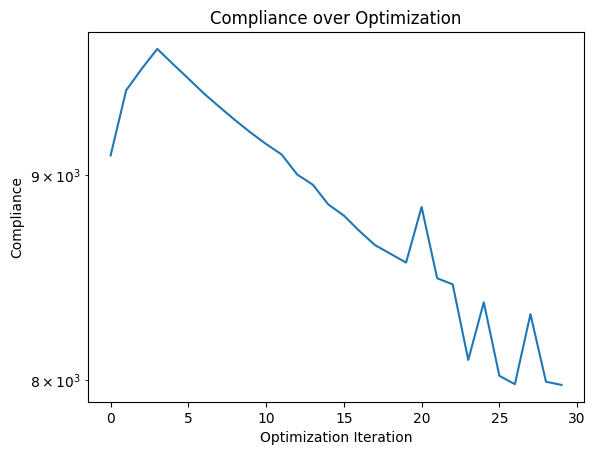

In [360]:
plt.plot(loss_hist)
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization");

In [ ]:
# lets visualize the 3d meshes over the optimization
for i, params in enumerate(params_hist):
    design_out = design_tess.apply(
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        }
    )
    surface_mesh = design_out["mesh"]

    num_vertices = surface_mesh["n_points"]
    num_faces = surface_mesh["n_faces"]

    points = surface_mesh["points"][:num_vertices]
    faces = surface_mesh["faces"][:num_faces]

    mesh = {
        "points": points,
        "faces": faces,
    }

    plot_mesh(mesh, save_path=f"tmp_img/mesh_optim_{i:03d}.png")